In [1]:
import tensorflow as tf;
print("Tensorflow Version: ",tf.__version__)

import keras as keras
print("Keras Version: ",keras.__version__)

D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

Tensorflow Version:  1.13.2
Keras Version:  2.2.4


Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
np.random.seed(1)

In [3]:
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

## 1 - Overview of the data set

First of all, we'll load the data. After loading, here's a basic overview;

- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

In [4]:
train_dataset = h5py.File('./data/train.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

test_dataset = h5py.File('./data/test.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

In [5]:
classes = np.array(test_dataset["list_classes"][:]) # the list of classes
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [6]:
train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
print(train_set_y.shape)
print(test_set_y.shape)

(1, 209)
(1, 50)


Each line of train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the index value and re-run to see other images.

y = [1], it's a 'cat' picture.


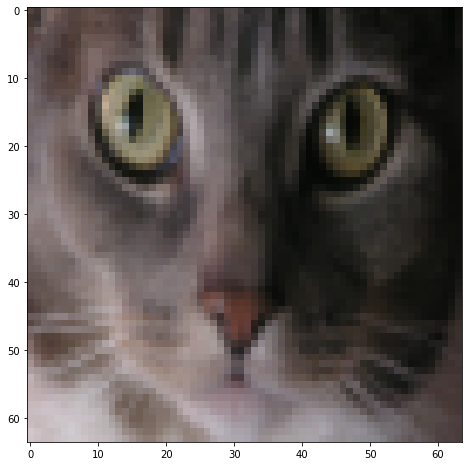

In [7]:
# Example of a picture
index = 60
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

# 2 - Data preprocessing

Following are the steps to preprocess data for a ConvNet.

- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- "Standardize" the data
- Data Augmentation (will discuss later in the course)

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

### 2.1 Dimensions of our data

In [8]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Dataset dimensions:")
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")

Dataset dimensions:
Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)


In [9]:
train_set_y = train_set_y.T
test_set_y = test_set_y.T

In [10]:
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (209, 1)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (50, 1)


### 2.3 Standardizing data

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.

In [11]:
train_set_x = train_set_x_orig/255.
test_set_x = test_set_x_orig/255.

In [12]:
train_set_x.shape

(209, 64, 64, 3)

## 3 - Modeling

### 3.1 Utility function to train & evaluate our models.

In [13]:
# Utility function
def evaluate_this_model(model, epochs):
    
    np.random.seed(1)

    history = model.fit(train_set_x, train_set_y,epochs=epochs)
    results = model.evaluate(test_set_x, test_set_y)
    
    plt.plot(np.squeeze(history.history["loss"]))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    print("\n\nAccuracy on training set is {}".format(history.history["acc"][-1]))
    print("\nAccuracy on test set is {}".format(results[1]))

### 3.2 Model Architecture

In [14]:
model = Sequential()

model.add(Conv2D(10,nb_row=3, nb_col=3, activation='relu', input_shape=(64,64,3)))
#model.add(Conv2D(10, kernel_size=3, activation= 'relu', input_shape=train_set_x.shape[1:]  ))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(15, nb_row=3, nb_col=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(20,nb_row=3, nb_col=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(35, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))




Instructions for updating:
Colocations handled automatically by placer.


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (3, 3), activation="relu", input_shape=(64, 64, 3...)`
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(15, (3, 3), activation="relu")`
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.


### 3.3 Compilation

In [15]:
learning_rate = 0.0001
opt = Adam(lr=learning_rate)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 10)        280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 15)        1365      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 20)        2720      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 720)               0         
__________

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
209/209 [==============================] - 1s 6ms/step - loss: 0.6851 - acc: 0.5837
Epoch 2/100
209/209 [==============================] - 1s 3ms/step - loss: 0.6683 - acc: 0.6411
Epoch 3/100
209/209 [==============================] - 1s 3ms/step - loss: 0.6589 - acc: 0.6411
Epoch 4/100
209/209 [==============================] - 1s 4ms/step - loss: 0.6532 - acc: 0.6555
Epoch 5/100
209/209 [==============================] - 1s 5ms/step - loss: 0.6480 - acc: 0.6555
Epoch 6/100
209/209 [==============================] - 1s 4ms/step - loss: 0.6451 - acc: 0.6555
Epoch 7/100
209/209 [==============================] - 1s 4ms/step - loss: 0.6428 - acc: 0.6555
Epoch 8/100
209/209 [==============================] - 1s 5ms/step - loss: 0.6412 - acc: 0.6555
Epoch 9/100
209/209 [==============================] - 1s 4ms/step - loss: 0.6400 - acc: 0.6555
Epoch 10/100
209/209 [==============================] - 1s 4ms/step - loss: 0.6414 - acc

209/209 [==============================] - 1s 5ms/step - loss: 0.2256 - acc: 0.9234
Epoch 84/100
209/209 [==============================] - 1s 4ms/step - loss: 0.2193 - acc: 0.9282
Epoch 85/100
209/209 [==============================] - 1s 4ms/step - loss: 0.2134 - acc: 0.9330
Epoch 86/100
209/209 [==============================] - 1s 5ms/step - loss: 0.2101 - acc: 0.9330
Epoch 87/100
209/209 [==============================] - 1s 5ms/step - loss: 0.2093 - acc: 0.9378
Epoch 88/100
209/209 [==============================] - 1s 5ms/step - loss: 0.2084 - acc: 0.9330
Epoch 89/100
209/209 [==============================] - 1s 5ms/step - loss: 0.2003 - acc: 0.9378
Epoch 90/100
209/209 [==============================] - 1s 5ms/step - loss: 0.2067 - acc: 0.9282
Epoch 91/100
209/209 [==============================] - 1s 5ms/step - loss: 0.2025 - acc: 0.9330
Epoch 92/100
209/209 [==============================] - 1s 5ms/step - loss: 0.2065 - acc: 0.9330
Epoch 93/100
209/209 [=====================

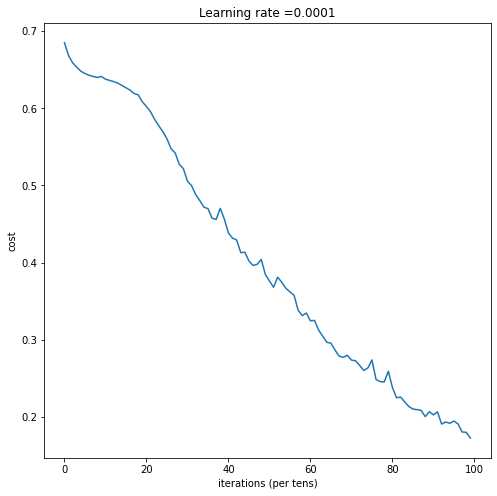



Accuracy on training set is 0.942583732342606

Accuracy on test set is 0.8400000023841858


In [17]:
evaluate_this_model(model, 100)

## 4 - Improving Accuracy

In [18]:
def evaluate_my_model(epochs):
    
    np.random.seed(1)
    
    train_accuracies = []
    test_accuracies = []
    

    model = get_model()
    history = model.fit(train_set_x, train_set_y, epochs=epochs)
    results = model.evaluate(test_set_x, test_set_y)
    train_accuracies.append(history.history["acc"][-1])
    test_accuracies.append(results[1])

    plt.plot(np.squeeze(history.history["loss"]))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Last iteration")
    plt.show()
    
    print(train_accuracies)
    print(test_accuracies)
    print("\n\nAccuracy on training set is {}".format(np.mean(train_accuracies)))
    print("\nAccuracy on test set is {}".format(np.mean(test_accuracies)))

# Task 

In [19]:
from keras import regularizers
from keras.layers.normalization import BatchNormalization

In [20]:
def get_model():
    model = Sequential()
    ## TO DO: Improve the testing accuracy by making a CNN Architecture a bit complex 
    model.add(Conv2D(10, (3, 3), activation="relu", input_shape=(64,64,3)))
    #model.add(Conv2D(10, kernel_size=3, activation= 'relu', input_shape=train_set_x.shape[1:]  ))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(15, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(20, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(25, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(25, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    learning_rate = 0.001
    opt = Adam(lr=learning_rate)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 10)        280       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 15)        1365      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 20)        2720      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 20)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 25)          4525      
__________

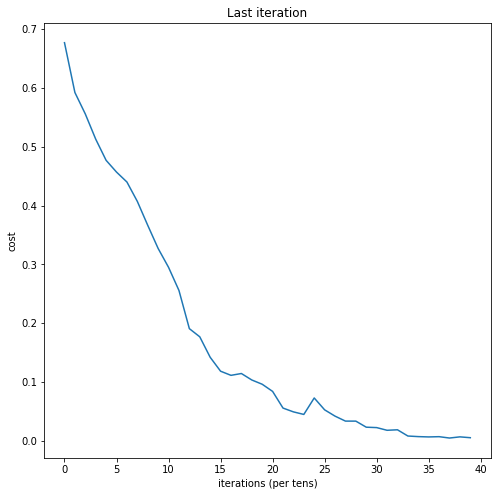

[1.0]
[0.96]


Accuracy on training set is 1.0

Accuracy on test set is 0.96


In [21]:
epochs = 40
evaluate_my_model(epochs)